(dimer)=
# Two coupled resonators

## Parameters initialization

We import all the necessary libraries in the usual way

In [12]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150
import numpy as np
import sys,os
my_PyCore_dir = os.path.dirname('/Users/aleksandrtusnin/Documents/Projects/PyCORe/')
sys.path.append(my_PyCore_dir)
import PyCORe_main as pcm
from scipy.constants import c, hbar
%matplotlib widget

For simplicity, we define the same dispersion for both resonators. 

In [3]:
Num_of_modes = 2**9
mu = np.arange(-Num_of_modes/2,Num_of_modes/2)
N_res = 2
Dint = np.zeros([Num_of_modes,N_res])
D2 = 4.1e6*2*np.pi
Dint[:,0] = (mu**2*D2/2) 
Dint[:,1] = (mu**2*D2/2) 

:::{admonition} Different resonators dispersion
:class: tip, dropdown
It can be readily implemeted via
```python
Dint[:,0] = (mu**2*D2_1/2) 
Dint[:,1] = (mu**2*D2_2/2) 
```
:::
:::{admonition} Defferent FSR
:class: tip, dropdown
Let's define the difference as $\Delta D_1$, then it can be readily taken intro account in the dispersion as
```python
Dint[:,0] = (mu**2*D2_1/2) 
Dint[:,1] = (mu*DeltaD1 + mu**2*D2_2/2) 
```
:::

Resonators often have different absolute frequencies, and we usually call it as intra-resonator detuning $\Delta$. This value depends on the material and fabrication. However, with photonic Damascene and  subtractive processes it can exceed tens of GHz. Here, we detune second resonator by $0.01$ GHz with respect to the first. In experiment, one usually put additional elements, such as heaters shown in the microscope image, to tune the resonators
```{image} ./img/dimer.jpg
:alt: fishy
:class: bg-primary mb-1
:width: 200px
:align: left
```

In [4]:
Delta = np.zeros([Num_of_modes,(N_res)])

Delta[:,1] = 2*np.pi*0.01e9*np.ones([Num_of_modes])

The evanescent coupling $J$ depends on the the resonators' geometry and on the distance between them. Usually, this value can be extractred from, for example, Lumerical simulations, or experiment. In PyCORe, we define it as  



In [5]:
J = 2*1e9*2*np.pi*np.ones([mu.size,(N_res-1)])

:::{admonition} Frequency dependent coupling
:class: tip, dropdown
In this particular example we defined the coupling to be frequency independent, however it's not always the case. It often has exponential dependence on the mode number $\mu$.
:::
We define the couplings to the bus waveguides in the similar way


In [6]:
kappa_ex_ampl = 20e6*2*np.pi
kappa_ex = np.zeros([Num_of_modes,N_res])
kappa_ex[:,0] = kappa_ex_ampl*np.ones([Num_of_modes])
kappa_ex[:,1] = 2*kappa_ex_ampl*np.ones([Num_of_modes])

We finally define the resonator parameters to initialize the class

In [7]:
omega = 2*np.pi*193.414489e12

PhysicalParameters = {'Inter-resonator_coupling': J,
                      'Resonator detunings' : Delta,
                      'n0' : 1.9,
                      'n2' : 2.4e-19,### m^2/W
                      'FSR' : 457.9e9 ,
                      'w0' : omega,
                      'width' : 2.35e-6,
                      'height' : 0.8e-6,
                      'kappa_0' : 20e6*2*np.pi,
                      'kappa_ex' : kappa_ex,
                      'Dint' : Dint}
crow = pcm.CROW()
crow.Init_From_Dict(PhysicalParameters)

Pump laser parameters and detuning parameters are defined in the similar way as for just single resonator, except there is a possibility to pump different resonators

In [8]:
dNu_ini = -2*1e9
dNu_end = 3e9

nn = 1000
dOm = 2*np.pi*np.linspace(dNu_ini,dNu_end,nn)
simulation_parameters = {'slow_time' : 1e-6,
                         'detuning_array' : dOm,
                         'noise_level' : 1e-9,
                         'output' : 'map',
                         'absolute_tolerance' : 1e-10,
                         'relative_tolerance' : 1e-12,
                         'max_internal_steps' : 2000}

P0 = 0.3### W

Pump = np.zeros([len(mu),N_res],dtype='complex')

Pump[0,0] = np.sqrt(P0)

In [9]:
map2d = crow.Propagate_PSEUDO_SPECTRAL_SAMCLIB(simulation_parameters, Pump, BC='OPEN')

f0^2 = [5682.39    0.  ]
xi [-200.0,299.99999999999994] (normalized on $kappa_0/2)$
OPEN
Initializing pseudo spectral CROW
speudo spetral CROW is initialized
Step adaptative pseudo-spectral Dopri853  from NR3 without thermal effects is running
100% [||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||]

Similar to the single resonator case from [single-resonator example](quick_start), we plot the transmission traces from both resonators

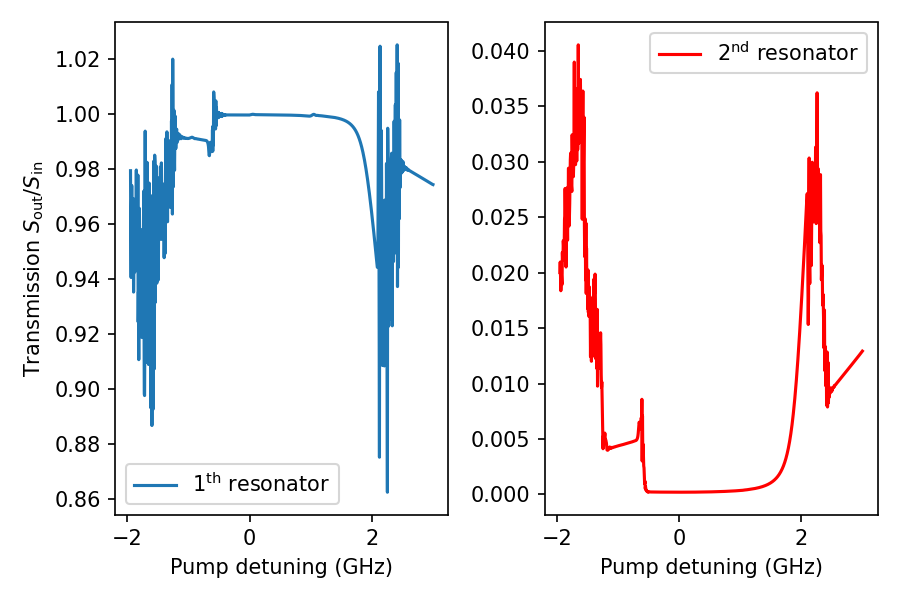

In [28]:
Sin = Pump/np.sqrt(hbar*PhysicalParameters['w0'])
Sout = np.zeros_like(map2d)
Sout = Sin - np.sqrt(crow.kappa_ex)*map2d/Num_of_modes

fig = plt.figure(figsize=[6,4],frameon=False,dpi=150)
ax = fig.add_subplot(1,2,1)
ax.plot(dOm[10:]/2/np.pi/1e9,np.sum(abs(Sout[10:,:,0])**2,axis=1)/np.max(abs(Sin)**2),label='1$^{\mathrm{th}}$ resonator')
ax.set_ylabel(r'Transmission $S_\mathrm{out}/S_\mathrm{in}$')
ax.set_xlabel('Pump detuning (GHz)')
plt.legend()
ax = fig.add_subplot(1,2,2)
ax.plot(dOm[10:]/2/np.pi/1e9,np.sum(abs(Sout[10:,:,1])**2,axis=1)/np.max(abs(Sin)**2),c='r',label='2$^{\mathrm{nd}}$ resonator')
ax.set_xlabel('Pump detuning (GHz)')
plt.legend()
plt.tight_layout()


The function ``` Plot_map ``` can also be used to interactively investigate resonator dynamics.

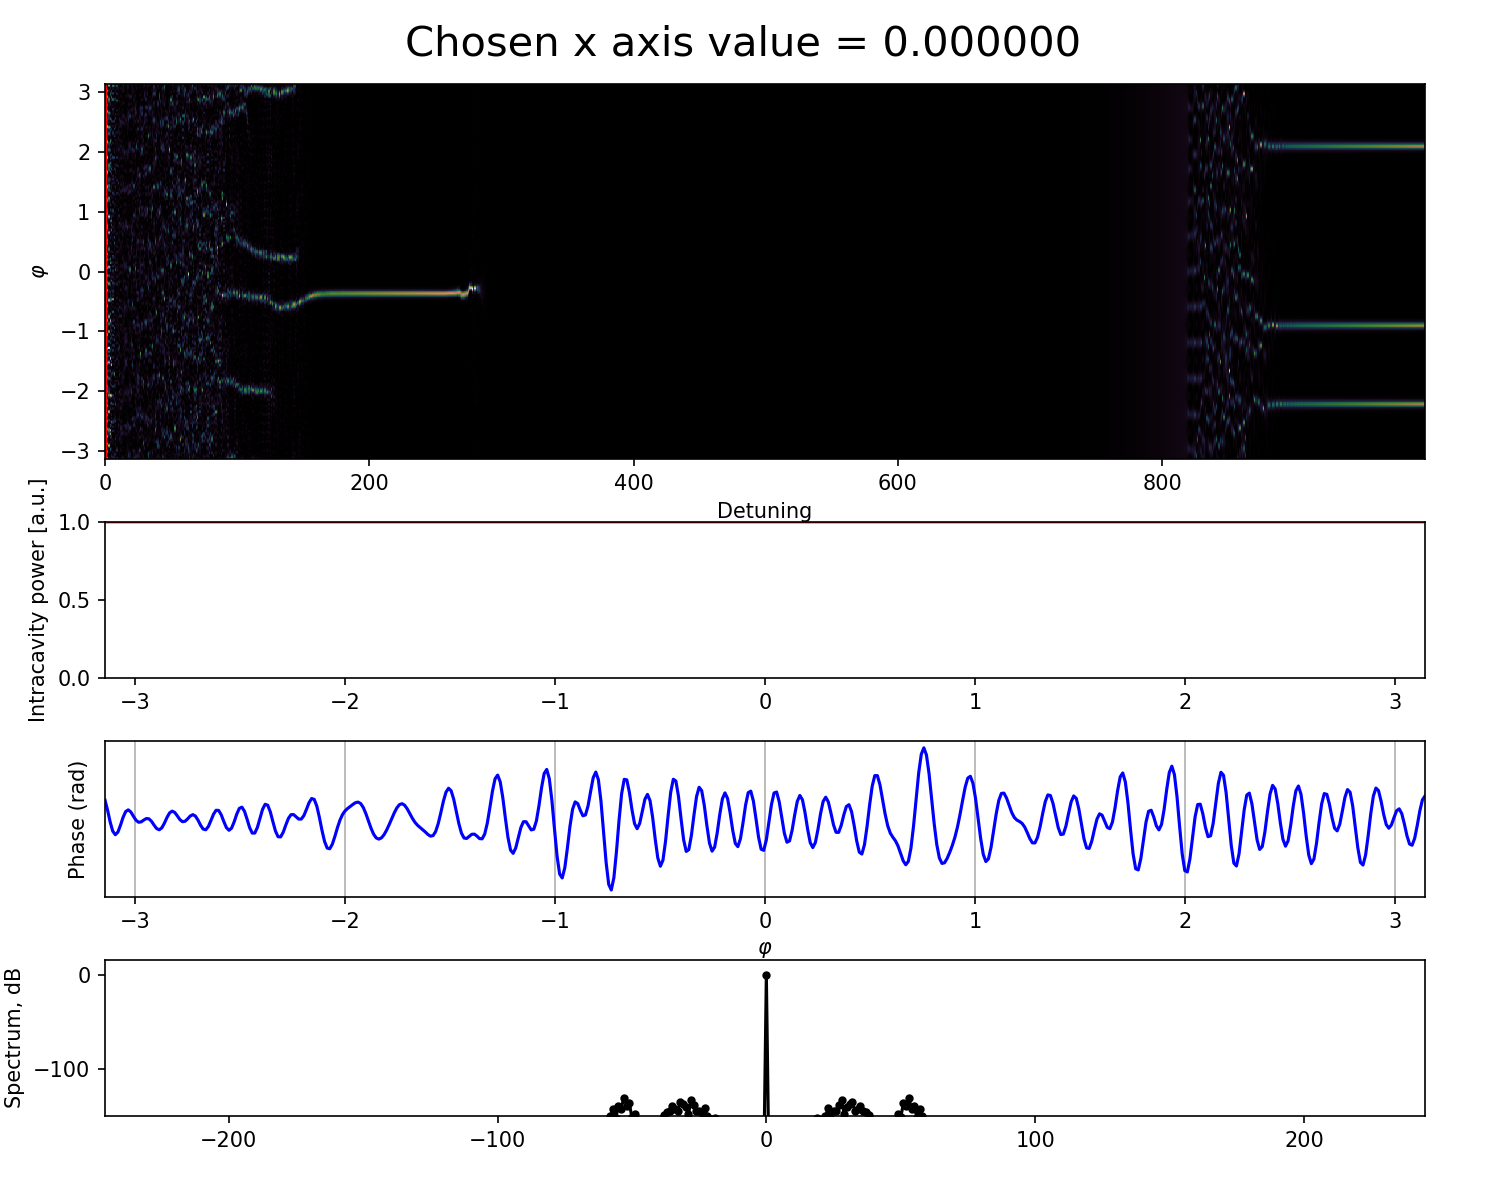

In [19]:
pcm.Plot_Map(np.fft.ifft(Sout[:,:,1],axis=1),np.arange(dOm.size),xlabel='Detuning index', units='')